In [1]:
pip install git+https://github.com/hudscomdz/scikit-anfis.git

  Cloning https://github.com/hudscomdz/scikit-anfis.git to c:\users\almer\appdata\local\temp\pip-req-build-04oz90o1
  Resolved https://github.com/hudscomdz/scikit-anfis.git to commit 790db6bcad7da531e9905b19311f07bec0c1ff5b
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
Note: you may need to restart the kernel to use updated packages.


  Running command git clone --filter=blob:none --quiet https://github.com/hudscomdz/scikit-anfis.git 'C:\Users\Almer\AppData\Local\Temp\pip-req-build-04oz90o1'


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from skanfis.fs import FS, TriangleFuzzySet, LinguisticVariable
from skanfis import scikit_anfis

In [3]:
data = pd.read_csv('C:/Users/Almer/Desktop/Crop_recommendation.csv')
target_crops = ['rice', 'maize', 'chickpea', 'kidneybeans', 'pigeonpeas', 'mothbeans']
df = data[data['label'].isin(target_crops)].copy()

In [4]:
crop_mapping = {label: idx for idx, label in enumerate(target_crops)}
inv_crop_mapping = {idx: label for label, idx in crop_mapping.items()}
df['label_code'] = df['label'].map(crop_mapping)

In [5]:
features = ['N', 'P', 'K', 'temperature', 'humidity', 'rainfall']
X = df[features].values
y = df['label_code'].values.reshape(-1, 1)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [7]:
fs = FS()

In [8]:
for i, col_name in enumerate(features):
    col_min = df[col_name].min()
    col_max = df[col_name].max()
    col_mean = df[col_name].mean()
    
    S_Low = TriangleFuzzySet(a=col_min, b=col_min, c=col_mean, term="Low")
    
    S_Med = TriangleFuzzySet(a=col_min, b=col_mean, c=col_max, term="Medium")
    
    S_High = TriangleFuzzySet(a=col_mean, b=col_max, c=col_max, term="High")
    
    fs.add_linguistic_variable(col_name, LinguisticVariable([S_Low, S_Med, S_High], concept=col_name))

In [9]:
for name, idx in crop_mapping.items():
    fs.set_crisp_output_value(name, idx)

 * Detected Sugeno model type


In [10]:
rules = []
grouped = df.groupby('label')[features].mean()

In [11]:
def get_term(value, col_name, dataframe):
    vmin = dataframe[col_name].min()
    vmax = dataframe[col_name].max()
    vmean = dataframe[col_name].mean()
    if value < (vmin + (vmean-vmin)/2): return "Low"
    if value > (vmax - (vmax-vmean)/2): return "High"
    return "Medium"

In [12]:
for crop_name in target_crops:
    means = grouped.loc[crop_name]
    
    rule_parts = []
    for feature in features:
        val = means[feature]
        term = get_term(val, feature, df)
        rule_parts.append(f"({feature} IS {term})")
    
    condition = " AND ".join(rule_parts)
    rule_str = f"IF {condition} THEN (Crop IS {crop_name})"
    rules.append(rule_str)
    
fs.add_rules(rules)

print(f"Згенеровано {len(rules)} базових правил.")
print("Приклад правила:", rules[0])

Згенеровано 6 базових правил.
Приклад правила: IF (N IS High) AND (P IS Medium) AND (K IS Medium) AND (temperature IS Medium) AND (humidity IS High) AND (rainfall IS High) THEN (Crop IS rice)


In [13]:
model = scikit_anfis(fs, epoch=20, hybrid=True)
train_data_combined = np.hstack((X_train, y_train))
history = model.fit(train_data_combined)

In [14]:
y_pred_raw = model.predict(X_test)
y_pred = np.round(y_pred_raw).flatten()
y_pred = np.clip(y_pred, 0, len(target_crops) - 1)
acc = accuracy_score(y_test, y_pred)
print(f"ТОЧНІСТЬ МОДЕЛІ: {acc * 100:.2f}%")

ТОЧНІСТЬ МОДЕЛІ: 96.67%


In [15]:
print(classification_report(y_test, y_pred, target_names=target_crops, zero_division=0))

              precision    recall  f1-score   support

        rice       0.86      1.00      0.93        38
       maize       1.00      0.97      0.98        31
    chickpea       1.00      1.00      1.00        29
 kidneybeans       1.00      0.88      0.93        24
  pigeonpeas       1.00      0.96      0.98        25
   mothbeans       1.00      0.97      0.98        33

    accuracy                           0.97       180
   macro avg       0.98      0.96      0.97       180
weighted avg       0.97      0.97      0.97       180



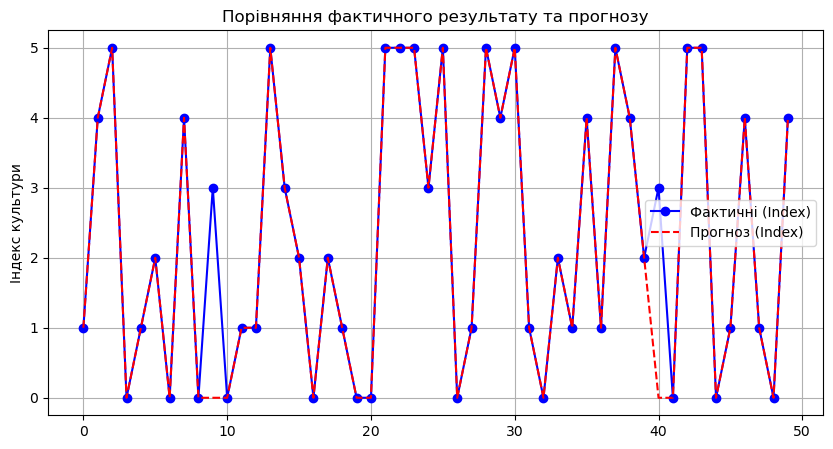

In [18]:
plt.figure(figsize=(10, 5))
plt.plot(y_test[:50], 'bo-', label='Фактичні (Index)')
plt.plot(y_pred[:50], 'r--', label='Прогноз (Index)')
plt.title("Порівняння фактичного результату та прогнозу")
plt.ylabel("Індекс культури")
plt.legend()
plt.grid(True)
plt.show()